# Load everything

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import numpy as np

import tensorflow as tf
import os
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch import nn


import harm_oscil_system
import deepxde as dde
#from spaces import FinitePowerSeries, FiniteChebyshev, GRF
#from system import LTSystem, ODESystem, DRSystem, CVCSystem, ADVDSystem
#from utils import merge_values, trim_to_65535, mean_squared_error_outlier, safe_test

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [4]:
def mse(y_pred, y_true, omega=None):
    return torch.mean((y_true - y_pred) ** 2)

def l2_relative_error(pred, target, std=False):
    num_samples = pred.shape[0]
    error = pred - target
    l2_err = torch.zeros(num_samples, dtype=torch.float64, device=pred.device)
    for i in range(num_samples):
        error_norm =torch.sum(error[i]**2)
        target_norm = torch.sum(target[i]**2)
        
        if target_norm == 0:
            if torch.sum(pred[i]**2) == 0:
                rel_error = 0.0
            else:
                rel_error = 1.0
        else:
            rel_error = torch.sqrt(error_norm / target_norm)
        l2_err[i] = rel_error
    
    if std:
        return torch.mean(l2_err), torch.std(l2_err)
    
    return torch.mean(l2_err)

def energy_loss(y_pred, y_true, omega, std=False):
    nt = y_pred.shape[-2]
    energies_pred = 0.5*(y_pred[:, :,1]**2 + (omega*y_pred[:, :, 0])**2)
    energies_true = 0.5*(y_true[:, :,1]**2 + (omega*y_true[:, :, 0])**2)
    
    E_mse = torch.abs(energies_pred - energies_true) ** 2
    energy_loss = torch.mean(E_mse)
    
    if std:
        energy_loss_std = torch.std(E_mse)
        return energy_loss, energy_loss_std
    
    return energy_loss

def mse_energy_loss(y_pred, y_true, omega):
    return mse(y_pred, y_true) + energy_loss(y_pred, y_true, omega)
    

In [5]:
def model_energy_v2_batch_multi(X, net, omega): # take in num_datax1
    x_func=net.branch(torch.tensor(X[0])) # output num_datax 2x2, num_datax 4
    
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1)))
    # Split x_func into respective outputs
    
    x_func = x_func.view(x_func.shape[0], 2, -1).to(torch.float64)
    x_loc = torch.transpose(x_loc, 0, 1).to(torch.float64)

    p0 = torch.tensor(X[0][:, 0])
    q0 = torch.tensor(X[0][:, 1])
    
    E = 0.5* ((omega*p0)**2 +q0**2)
    
    W_sqrt = torch.tensor([[omega, 0], [0, 1]]).double()
    W_sqrt_inv = torch.tensor([[1/omega, 0], [0, 1]]).double()
    
    B_tilde = torch.einsum("pn, mnl ->mpl", W_sqrt, x_func).double()
    
    Q_tilde, R = torch.linalg.qr(B_tilde)
    
    alpha_tilde = torch.matmul(R, x_loc)
    
    norm_alpha_tilde = torch.linalg.vector_norm(alpha_tilde, dim=1, keepdim=True)
    zero_mask = (norm_alpha_tilde == 0)
    safe_norm = torch.where(zero_mask, torch.ones_like(norm_alpha_tilde), norm_alpha_tilde)
    alpha_scaled = alpha_tilde* torch.sqrt(2*E).unsqueeze(1).unsqueeze(2) / safe_norm
    
    basis = torch.einsum("pn, mnl ->mpl",W_sqrt_inv, Q_tilde).double()
    result = torch.bmm(basis, alpha_scaled) # + b_batch
    
    return result.permute(0, 2, 1).squeeze()


def model_multi(X, net, omega): # take in num_datax1
    x_func=net.branch(torch.tensor(X[0])) # output num_datax 2x2, num_datax 4
    x_loc = net.activation_trunk(net.trunk(torch.tensor(X[1]).unsqueeze(-1)))
    # Split x_func into respective outputs
    
    x_func = x_func.view(x_func.shape[0], 2, -1).to(torch.float64)
    x_loc = torch.transpose(x_loc, 0, 1).to(torch.float64)
    
    result = torch.matmul(x_func, x_loc).to(torch.float64)
    
    return result.permute(0, 2, 1).squeeze()

# Load nets

In [6]:
activation = "relu"
initializer = "Glorot normal"  # "He normal" or "Glorot normal"
dim_x = 1 


harm_net = dde.nn.DeepONet(
    [2, 40, 40],
    [dim_x, 40, 20],
#    [2, 4, 4],
#    [dim_x, 4, 2],
    activation,
    initializer,
    num_outputs = 2,
    #multi_output_strategy="independent_energy"# For harmonic oscillator
    #ulti_output_strategy="split_both_energy"
    multi_output_strategy="split_branch"
) 


harm_energy_net = dde.nn.DeepONet(
    [2, 40, 40],
    [dim_x, 40, 20],
#    [2, 4, 4],
#    [dim_x, 4, 2],
    activation,
    initializer,
    num_outputs = 2,
    #multi_output_strategy="independent_energy"# For harmonic oscillator
    #ulti_output_strategy="split_both_energy"
    multi_output_strategy="split_branch"
) 

harm_EI_net = dde.nn.DeepONet(
    [2, 40, 40],
    [dim_x, 40, 20],
#    [2, 4, 4],
#    [dim_x, 4, 2],
    activation,
    initializer,
    num_outputs = 2,
    #multi_output_strategy="independent_energy"# For harmonic oscillator
    #ulti_output_strategy="split_both_energy"
    multi_output_strategy="split_branch"
) 

In [13]:
%cd C:\Users\zzh\Desktop\Oxford\dissertation\deeponet

C:\Users\zzh\Desktop\Oxford\dissertation\deeponet


c:\Users\zzh\Desktop\Oxford\dissertation\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [14]:
harm_multi_checkpoint = torch.load("trained_nets/model_multi_epoch10000_net-40-20_loss-mse.pt", map_location=torch.device('cpu'))
harm_energy_checkpoint = torch.load("trained_nets/model_energy_v2_batch_multi_epoch10000_net-40-20_loss-mse.pt", map_location=torch.device('cpu'))
harm_EI_checkpoint = torch.load("trained_nets/model_multi_epoch10000_net-40-20_loss-mse_energy_loss.pt", map_location=torch.device('cpu'))

harm_net.load_state_dict(harm_multi_checkpoint['model_state_dict'])
harm_energy_net.load_state_dict(harm_energy_checkpoint['model_state_dict'])
harm_EI_net.load_state_dict(harm_EI_checkpoint['model_state_dict'])

C:\Users\zzh\AppData\Local\Temp\ipykernel_4784\1958587258.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  harm_multi_checkpoint = torch.load("trained_nets/model_multi_ep

<All keys matched successfully>

Text(0.5, 1.0, 'Test Error')

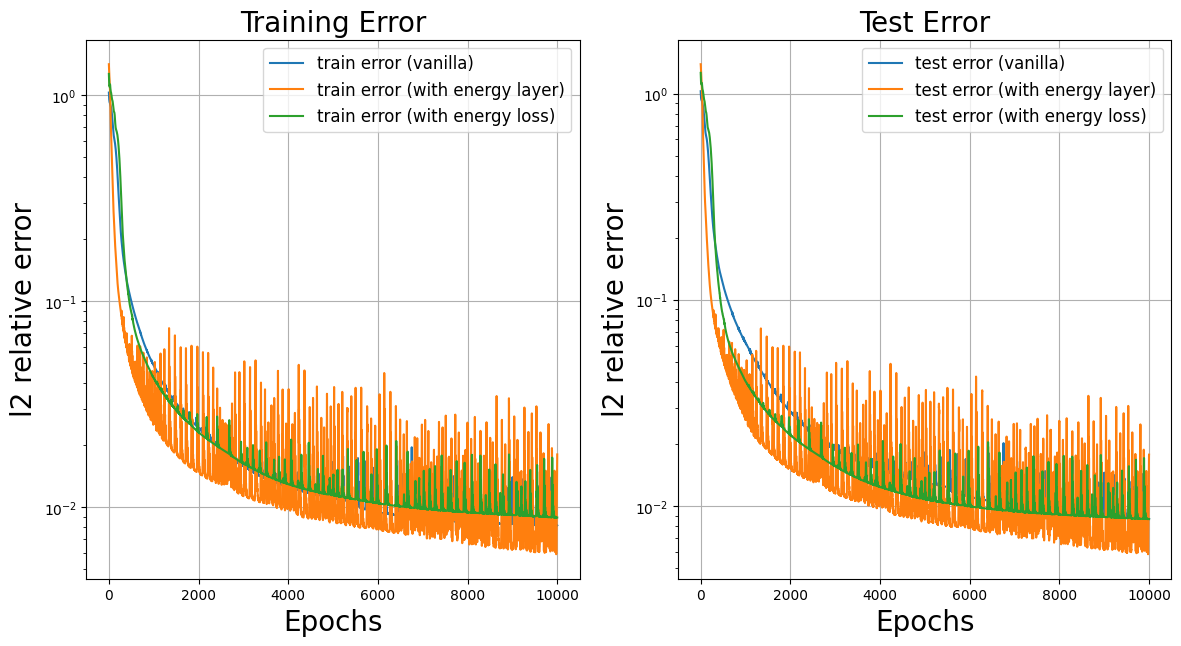

In [15]:
fontsize = 20
harm_multi_train_err = harm_multi_checkpoint['train_errors']
harm_energy_train_err = harm_energy_checkpoint['train_errors']
harm_EI_train_err = harm_EI_checkpoint['train_errors']


harm_multi_test_err = harm_multi_checkpoint['test_errors']
harm_energy_test_err = harm_energy_checkpoint['test_errors']
harm_EI_test_err = harm_EI_checkpoint['test_errors']

fig, (ax1, ax2) = plt.subplots(1, 2 , figsize=(14,7))
ax1.plot(harm_multi_train_err, label='train error (vanilla)')
ax1.plot(harm_energy_train_err, label='train error (with energy layer)')
ax1.plot(harm_EI_train_err, label='train error (with energy loss)')
ax1.legend(prop={'size': 12})
ax1.grid(True)
ax1.set_yscale('log')
ax1.set_xlabel('Epochs', fontsize=fontsize)
ax1.set_ylabel('l2 relative error', fontsize=fontsize)
ax1.set_title('Training Error', fontsize=fontsize)

ax2.plot(harm_multi_test_err, label='test error (vanilla)')
ax2.plot(harm_energy_test_err, label='test error (with energy layer)')
ax2.plot(harm_EI_test_err, label='test error (with energy loss)')
ax2.legend(prop={'size': 12})
ax2.grid(True)
ax2.set_yscale('log')
ax2.set_xlabel('Epochs', fontsize=fontsize)
ax2.set_ylabel('l2 relative error', fontsize=fontsize)
ax2.set_title('Test Error', fontsize=fontsize)



In [67]:
print(harm_multi_test_err[-1],harm_energy_test_err[-1],harm_EI_test_err[-1])

0.008673962504092582 0.017774078420284736 0.008657927821743648


# Generate datasets

In [16]:
m = 50
T = 10
omega = 1.0
L = 2

num_test = 1000

X_test, y_test = harm_oscil_system.gen_harm_multi(omega, L, T, num_test, m)

In [17]:
with torch.no_grad():
    y_pred = model_multi(X_test,net = harm_net, omega=omega)
    y_pred_energy = model_energy_v2_batch_multi(X_test,net = harm_energy_net,omega= omega)
    y_pred_EI = model_multi(X_test,net=harm_EI_net,omega= omega)

In [17]:
y_pred.shape

torch.Size([400, 50, 2])

In [18]:
print("Vanila")
l2_err, l2_std = l2_relative_error(y_pred, torch.tensor(y_test,dtype=torch.float64), std=True)
energy_mse, energy_std = energy_loss(y_pred, torch.tensor(y_test,dtype=torch.float64), omega, std=True)
print(f"L2 error: {l2_err:.6f} ± {l2_std:.6f}")
print(f"Energy loss: {energy_mse:.6f} ± {energy_std:.6f}")
print("----------------------------------------------------------")

print("With Energy layer")
l2_err, l2_std = l2_relative_error(y_pred_energy, torch.tensor(y_test,dtype=torch.float64), std=True)
energy_mse, energy_std = energy_loss(y_pred_energy, torch.tensor(y_test,dtype=torch.float64), omega, std=True)
print(f"L2 error: {l2_err:.6f} ± {l2_std:.6f}")
print(f"Energy loss: {energy_mse:.6f} ± {energy_std:.6f}")
print("----------------------------------------------------------")

print("With energy loss")
l2_err, l2_std = l2_relative_error(y_pred_EI, torch.tensor(y_test,dtype=torch.float64), std=True)
energy_mse, energy_std = energy_loss(y_pred_EI, torch.tensor(y_test,dtype=torch.float64), omega, std=True)
print(f"L2 error: {l2_err:.6f} ± {l2_std:.6f}")
print(f"Energy loss: {energy_mse:.6f} ± {energy_std:.6f}")
print("----------------------------------------------------------")

Vanila
L2 error: 2.520403 ± 0.048140
Energy loss: 161.658756 ± 487.974594
----------------------------------------------------------
With Energy layer
L2 error: 1.054668 ± 0.003533
Energy loss: 0.000000 ± 0.000000
----------------------------------------------------------
With energy loss
L2 error: 1.856312 ± 0.042910
Energy loss: 26.265037 ± 79.827248
----------------------------------------------------------


In [19]:
i = 9
E_true = 0.5*(y_test[i, :, 1]**2 + (omega*y_test[i, :, 0])**2)
E_pred = 0.5*(y_pred[i, :, 1].numpy()**2 + (omega*y_pred[i, :, 0].numpy())**2)
E_energy = 0.5*(y_pred_energy[i, :, 1].numpy()**2 + (omega*y_pred_energy[i, :, 0].numpy())**2)
E_EI = 0.5*(y_pred_EI[i, :, 1].numpy()**2 + (omega*y_pred_EI[i, :, 0].numpy())**2)

Text(0.5, 1.0, 'Total energy over time')

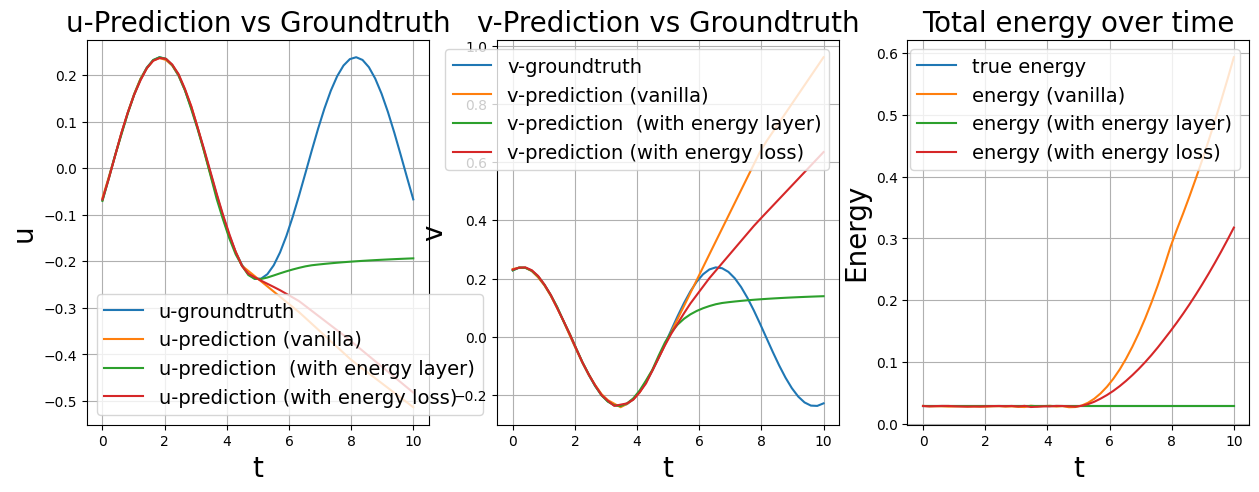

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3 , figsize=(15,5))
t = np.linspace(0, T, m)
fontsize=20
ax1.plot(t, y_test[i, :, 0], label='u-groundtruth')
ax1.plot(t, y_pred[i, :, 0].numpy(), label='u-prediction (vanilla)')
ax1.plot(t, y_pred_energy[i, :, 0].numpy(), label='u-prediction  (with energy layer)')
ax1.plot(t, y_pred_EI[i, :, 0].numpy(), label='u-prediction (with energy loss)')
ax1.legend(prop={'size': 14})
ax1.grid(True)
ax1.set_xlabel('t', fontsize=fontsize)
ax1.set_ylabel('u', fontsize=fontsize)
ax1.set_title('u-Prediction vs Groundtruth', fontsize=fontsize)

ax2.plot(t, y_test[i, :, 1], label='v-groundtruth')
ax2.plot(t, y_pred[i, :, 1].numpy(), label='v-prediction (vanilla)')
ax2.plot(t, y_pred_energy[i, :, 1].numpy(), label='v-prediction  (with energy layer)')
ax2.plot(t, y_pred_EI[i, :, 1].numpy(), label='v-prediction (with energy loss)')
ax2.legend(prop={'size': 14})
ax2.grid(True)
ax2.set_xlabel('t', fontsize=fontsize)
ax2.set_ylabel('v', fontsize=fontsize)
ax2.set_title('v-Prediction vs Groundtruth', fontsize=fontsize)

ax3.plot(t, E_true, label="true energy")
ax3.plot(t, E_pred, label='energy (vanilla)')
ax3.plot(t, E_energy, label='energy (with energy layer)')
ax3.plot(t, E_EI, label='energy (with energy loss)')
ax3.legend(prop={'size': 14})
ax3.grid(True)
ax3.set_xlabel('t', fontsize=fontsize)
ax3.set_ylabel('Energy', fontsize=fontsize)
ax3.set_title('Total energy over time', fontsize=fontsize)